In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Daten laden
data = pd.read_csv("balanced_data.csv")

# Annahme: Die Zielvariable heißt 'target' und die restlichen Spalten sind Features
X = data.drop('target', axis=1)  # Features
y = data['target']  # Zielvariable

# Falls die Zielvariable kategorisch ist, encode sie (z.B. 'Class_1', 'Class_2', ...)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [5]:
import xgboost as xgb

# XGBoost-Modell initialisieren
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Für Multiclass-Klassifikation
    num_class=len(np.unique(y_encoded)),  # Anzahl der Klassen
    eval_metric='mlogloss',  # Metrik für Multiclass
    random_state=42
)

# Modell trainieren
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=9, ...)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Vorhersagen auf Testdaten
y_pred = xgb_model.predict(X_test)

# Genauigkeit berechnen
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detaillierte Auswertung
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

# Konfusionsmatrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8286

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.86      0.83      1340
           2       0.70      0.65      0.67      1399
           3       0.65      0.63      0.64      1343
           4       0.76      0.84      0.80      1368
           5       0.99      0.99      0.99      1356
           6       0.92      0.90      0.91      1438
           7       0.83      0.83      0.83      1391
           8       0.90      0.89      0.90      1390
           9       0.90      0.87      0.88      1350

    accuracy                           0.83     12375
   macro avg       0.83      0.83      0.83     12375
weighted avg       0.83      0.83      0.83     12375


Confusion Matrix:
[[1153    7    2    1    0   20   48   50   59]
 [   4  912  291  139    4    2   30    4   13]
 [   4  270  840  162    0    3   56    6    2]
 [   6   69   98 1149    8   11   26    0    1]
 [   3    2    2    2 1342    0    5    0  

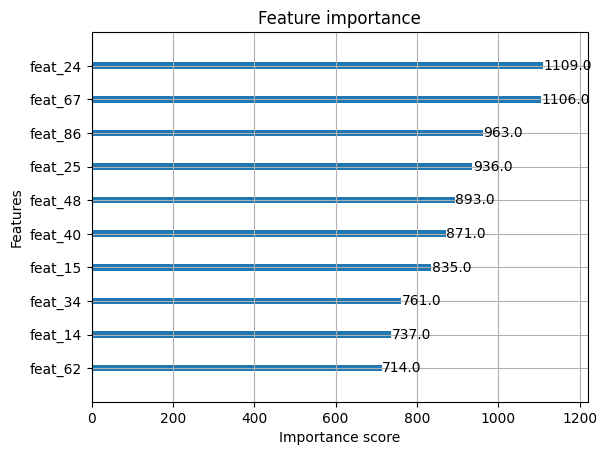

In [8]:
import matplotlib.pyplot as plt

# Feature Importance Plot
xgb.plot_importance(xgb_model, max_num_features=10)  # Top 10 Features
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV

# Parametergrid definieren
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# GridSearchCV initialisieren
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_encoded)), use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1
)

# Grid Search ausführen
grid_search.fit(X_train, y_train)

# Beste Parameter und Score
print("Beste Parameter:", grid_search.best_params_)
print("Beste Accuracy:", grid_search.best_score_)

# Beste Modell für Vorhersagen verwenden
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"Test Accuracy mit bestem Modell: {accuracy_score(y_test, y_pred_best):.4f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Beste Parameter: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Beste Accuracy: 0.7702828282828283
Test Accuracy mit bestem Modell: 0.7785
